# Deploying LoRA tuned models - Multitask

In [1]:
!date

Sun Mar 31 22:18:30 CEST 2024


In [2]:
!pwd

/Users/mkamp/code/peft_lora


In [3]:
#!pip install -Uq -r src/requirements.txt

In [4]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [5]:
import sys
sys.path.append('src')

In [6]:
from sagemaker.pytorch import PyTorch

import pandas as pd
import altair as alt
import time

import boto3
from nb_helper import *
sm = boto3.client('sagemaker')

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


INFO:util:Total parameters: 124,647,170, thereof learnable: 124,647,170 (100.0000%)


In [7]:
# One run with sst2,
# one training with sst2 LoRA, cola LoRA

In [8]:
get_default_estimator_parameters()

{'entry_point': 'train.py',
 'source_dir': 'src',
 'instance_type': 'ml.g5.xlarge',
 'instance_count': 1,
 'framework_version': '2.1',
 'py_version': 'py310',
 'base_job_name': 'lora',
 'use_spot_instances': True,
 'max_run': 68640,
 'max_wait': 68640,
 'role': 'arn:aws:iam::753739741425:role/admin',
 'metric_definitions': [{'Name': 'learning_rate',
   'Regex': "\\'learning_rate\\': (-?[0-9\\.e-]+)"},
  {'Name': 'train_epoch_duration', 'Regex': 'Epoch duration: (-?[0-9\\.]+)s'},
  {'Name': 'gpu_memory', 'Regex': 'GPU Usage.*?\\(([0-9\\.]+)% used\\)'},
  {'Name': 'train_samples_sec',
   'Regex': "\\'train_samples_per_second\\': (-?[0-9\\.]+)"},
  {'Name': 'valid_f1', 'Regex': "\\'eval_f1\\': (-?[0-9\\.]+)"},
  {'Name': 'sst2_valid_matthews_correlation',
   'Regex': "\\'eval_sst2_matthews_correlation\\': (-?[0-9\\.]+)"},
  {'Name': 'cola_valid_matthews_correlation',
   'Regex': "\\'eval_cola_matthews_correlation\\': (-?[0-9\\.]+)"},
  {'Name': 'sst2_valid_f1', 'Regex': "\\'eval_sst2_f1\\

In [9]:
sst2_fullft_estimator = PyTorch(**get_default_estimator_parameters())
sst2_fullft_estimator.set_hyperparameters(**{
    'n-warmup-steps':     5, 
    'seed':               42, 
    'tasks':              'sst2',
    
    'sst2-lora-config':   'none', 
    'sst2-batch-size':   192, # 480
    'sst2-learning-rate': 5.3e-5,
    'sst2-weight-decay':  0.1
})

In [10]:
sst2_fullft_estimator.hyperparameters()

{'tasks': '"\\"sst2\\""',
 'model-ckp': '"roberta-base"',
 'patience': '0',
 'n-train-samples': '0',
 'n-valid-samples': '0',
 'n-warmup-steps': '"5"',
 'warmup-ratio': '0.1',
 'seed': '"42"',
 'use-bf16': '1',
 'clf-dropout': '0.05',
 'hidden-dropout': '0.2',
 'attention-dropout': '0.2',
 'adam_beta1': '0.9',
 'adam_beta2': '0.98',
 'sst2-epochs': '10',
 'sst2-lora-config': '"\\"none\\""',
 'sst2-lora-dropout': '0.1',
 'sst2-batch-size': '"192"',
 'sst2-learning-rate': '"5.3e-05"',
 'sst2-weight-decay': '"0.1"',
 'cola-epochs': '10',
 'cola-lora-config': '"all"',
 'cola-lora-dropout': '0.05',
 'cola-batch-size': '224',
 'cola-learning-rate': '0.00085',
 'cola-weight-decay': '1e-09',
 'use-gradient-checkpointing': '0'}

In [11]:
sst2_fullft_estimator.fit(wait=False)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: lora-2024-03-31-20-18-38-053


In [12]:
sst2_cola_lora_estimator = PyTorch(**get_default_estimator_parameters())
sst2_cola_lora_estimator.set_hyperparameters(**{

    'n-warmup-steps':     5, 
    'seed':               42, 
    'tasks':              'sst2,cola',
    
    'sst2-lora-config':   'ff_u', 
    'sst2-lora-r':        4,
    'sst2-batch-size':    224, # 480
    'sst2-learning-rate': 2.3e-4,
    'sst2-weight-decay':  0.1,
    'sst2-lora-dropout':  0.15,
    
    'cola-lora-config':   'ff_u', 
    'cola-lora-r':        4,
    'cola-batch-size':    384, # 224 
    'cola-learning-rate': 9e-4,
    'cola-weight-decay':  0.3,
    'cola-lora-dropout':  0.3,
    
})

In [13]:
sst2_cola_lora_estimator.hyperparameters()

{'tasks': '"\\"sst2,cola\\""',
 'model-ckp': '"roberta-base"',
 'patience': '0',
 'n-train-samples': '0',
 'n-valid-samples': '0',
 'n-warmup-steps': '"5"',
 'warmup-ratio': '0.1',
 'seed': '"42"',
 'use-bf16': '1',
 'clf-dropout': '0.05',
 'hidden-dropout': '0.2',
 'attention-dropout': '0.2',
 'adam_beta1': '0.9',
 'adam_beta2': '0.98',
 'sst2-epochs': '10',
 'sst2-lora-config': '"\\"ff_u\\""',
 'sst2-lora-dropout': '"0.15"',
 'sst2-batch-size': '"224"',
 'sst2-learning-rate': '"0.00023"',
 'sst2-weight-decay': '"0.1"',
 'cola-epochs': '10',
 'cola-lora-config': '"\\"ff_u\\""',
 'cola-lora-dropout': '"0.3"',
 'cola-batch-size': '"384"',
 'cola-learning-rate': '"0.0009"',
 'cola-weight-decay': '"0.3"',
 'use-gradient-checkpointing': '0',
 'sst2-lora-r': '"4"',
 'cola-lora-r': '"4"'}

In [14]:
sst2_cola_lora_estimator.fit(wait=False)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: lora-2024-03-31-20-18-40-603


### Prepare Inference (Tokenizer / Data)

In [15]:
from util import evaluate_tasks
from train import tasks, prepare_data, load_model_and_tokenizer_and_collator
_, tokenizer , _   = load_model_and_tokenizer_and_collator('roberta-base')

INFO:datasets:PyTorch version 2.2.2 available.
'NoneType' object has no attribute 'cadam32bit_grad_fp32'
INFO:train:torch version: 2.2.2


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Data

In [16]:
sst2_data      = prepare_data(['sst2'], tokenizer)
cola_data      = prepare_data(['cola'], tokenizer)
sst2_cola_data = prepare_data(['sst2', 'cola'], tokenizer)

INFO:train:Preparing data for task: sst2
INFO:train:lapd called with n_train: None, n_valid: None
INFO:train:Average train input length: 14.36
INFO:train:Not randomizing order in input sequence.
INFO:train:Preparing data for task: cola
INFO:train:lapd called with n_train: None, n_valid: None
INFO:train:Average train input length: 11.37
INFO:train:Not randomizing order in input sequence.
INFO:train:Preparing data for task: sst2
INFO:train:lapd called with n_train: None, n_valid: None
INFO:train:Average train input length: 14.36
INFO:train:Preparing data for task: cola
INFO:train:lapd called with n_train: None, n_valid: None
INFO:train:Average train input length: 11.37
INFO:train:Not randomizing order in input sequence.


In [17]:
sst2_data[:2]

[('sst2', 1, "it 's a charming and often affecting journey . "),
 ('sst2', 0, 'unflinchingly bleak and desperate ')]

#### Deploying SST2 Endpoint

In [18]:
def get_job_metric(job, metric_names=None):
    if isinstance(metric_names, str):
        metrics = [metric_names]
        
    final_metrics = sm.describe_training_job(
        TrainingJobName=sst2_fullft_estimator.latest_training_job.job_name)['FinalMetricDataList']
    return [{fm['MetricName']: fm['Value']} for fm in final_metrics if metric_names is None or (fm['MetricName'] in metric_names)]

In [19]:
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=sst2_fullft_estimator.latest_training_job.job_name)

In [20]:
get_job_metric(sst2_fullft_estimator.latest_training_job.job_name, 'sst2_valid_acc')

[{'sst2_valid_acc': 0.9392201900482178}]

In [21]:
%%time
sst2_predictor = sst2_fullft_estimator.deploy(initial_instance_count=1, instance_type='ml.g4dn.xlarge') 

INFO:sagemaker:Repacking model artifact (s3://sagemaker-eu-west-1-753739741425/lora-2024-03-31-20-18-38-053/output/model.tar.gz), script artifact (s3://sagemaker-eu-west-1-753739741425/lora-2024-03-31-20-18-38-053/source/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-eu-west-1-753739741425/lora-2024-03-31-20-39-04-572/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: lora-2024-03-31-20-39-04-572
INFO:sagemaker:Creating endpoint-config with name lora-2024-03-31-20-39-04-572
INFO:sagemaker:Creating endpoint with name lora-2024-03-31-20-39-04-572
--------!CPU times: user 1min 31s, sys: 14.1 s, total: 1min 45s
Wall time: 7min 58s


In [22]:
def predict_standalone(inputs, tasks, bs=8):
    request = {
        'inputs': inputs, 
        'tasks': tasks, 
        'parameters': {'batch-size': bs}}
    return sst2_predictor.predict(request)

In [23]:
k = 7
measurements = []
def measure(name, f):
    for i in range(k):
        started = time.time()
        f()
        duration = time.time() - started
        measurements.append((name, duration))
        print(f'Measured {name} {duration:7.6f}s.')

#### Executing Inference SST2 Standalone

In [24]:
%%time
# Warmup with 10 records
_ = evaluate_tasks(predict_standalone, sst2_data[:10], inner_bs=10, task_aware=False)

.     correct      task prediction   y
        mean sum count        sum sum
task                                 
sst2     1.0  10    10          5   5
Overall acc: 1.0
CPU times: user 28.1 ms, sys: 9.93 ms, total: 38 ms
Wall time: 2.52 s


In [25]:
measure('Standalone SST-2', lambda: evaluate_tasks(predict_standalone, sst2_data, outer_bs=256, inner_bs=256, task_aware=False))

....      correct       task prediction    y
         mean  sum count        sum  sum
task                                    
sst2  0.93922  819   872        455  444
Overall acc: 0.9392201834862385
Measured Standalone SST-2 2.361973s.
....      correct       task prediction    y
         mean  sum count        sum  sum
task                                    
sst2  0.93922  819   872        455  444
Overall acc: 0.9392201834862385
Measured Standalone SST-2 2.331867s.
....      correct       task prediction    y
         mean  sum count        sum  sum
task                                    
sst2  0.93922  819   872        455  444
Overall acc: 0.9392201834862385
Measured Standalone SST-2 2.349175s.
....      correct       task prediction    y
         mean  sum count        sum  sum
task                                    
sst2  0.93922  819   872        455  444
Overall acc: 0.9392201834862385
Measured Standalone SST-2 2.353385s.
....      correct       task prediction    y
       

In [26]:
sst2_predictor.delete_model()
sst2_predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: lora-2024-03-31-20-39-04-572
INFO:sagemaker:Deleting endpoint configuration with name: lora-2024-03-31-20-39-04-572
INFO:sagemaker:Deleting endpoint with name: lora-2024-03-31-20-39-04-572


#### Deploying Multi-Task Endpoints

In [27]:
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=sst2_cola_lora_estimator.latest_training_job.job_name)

In [28]:
get_job_metric(sst2_cola_lora_estimator.latest_training_job.job_name, ['sst2_valid_acc', 'cola_valid_acc'])

[{'sst2_valid_acc': 0.9392201900482178}]

In [29]:
%%time
sst2_cola_lora_predictor = sst2_cola_lora_estimator.deploy(initial_instance_count=1, instance_type='ml.g4dn.xlarge')

INFO:sagemaker:Repacking model artifact (s3://sagemaker-eu-west-1-753739741425/lora-2024-03-31-20-18-40-603/output/model.tar.gz), script artifact (s3://sagemaker-eu-west-1-753739741425/lora-2024-03-31-20-18-40-603/source/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-eu-west-1-753739741425/lora-2024-03-31-20-47-23-961/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: lora-2024-03-31-20-47-23-961
INFO:sagemaker:Creating endpoint-config with name lora-2024-03-31-20-47-23-961
INFO:sagemaker:Creating endpoint with name lora-2024-03-31-20-47-23-961
--------!CPU times: user 3min 50s, sys: 5.76 s, total: 3min 55s
Wall time: 9min


In [30]:
def predict(inputs, tasks, bs):
    request = {
        'inputs': inputs, 
        'tasks': tasks,
        'parameters': {'batch-size': bs}
    } 
    return sst2_cola_lora_predictor.predict(request)

In [31]:
%%time
# Warmup with 10 records
_ = evaluate_tasks(predict, sst2_data[:10], inner_bs=128);

.     correct      task prediction   y
        mean sum count        sum sum
task                                 
sst2     1.0  10    10          5   5
Overall acc: 1.0
CPU times: user 30.7 ms, sys: 5.98 ms, total: 36.6 ms
Wall time: 787 ms


# Now running inference in task aware mode on the LoRA trained task head for SST-2.

In [32]:
measure('SST-2 LoRA', lambda: evaluate_tasks(predict, sst2_data, inner_bs=256))

....       correct       task prediction    y
          mean  sum count        sum  sum
task                                     
sst2  0.941514  821   872        453  444
Overall acc: 0.9415137614678899
Measured SST-2 LoRA 2.340473s.
....       correct       task prediction    y
          mean  sum count        sum  sum
task                                     
sst2  0.941514  821   872        453  444
Overall acc: 0.9415137614678899
Measured SST-2 LoRA 2.306693s.
....       correct       task prediction    y
          mean  sum count        sum  sum
task                                     
sst2  0.941514  821   872        453  444
Overall acc: 0.9415137614678899
Measured SST-2 LoRA 2.307383s.
....       correct       task prediction    y
          mean  sum count        sum  sum
task                                     
sst2  0.941514  821   872        453  444
Overall acc: 0.9415137614678899
Measured SST-2 LoRA 2.307755s.
....       correct       task prediction    y
          mean

# Now running inference in task aware mode on the LoRA trained task head for CoLA.

In [33]:
measure('CoLA LoRA', lambda: evaluate_tasks(predict, cola_data, inner_bs=256))

.....       correct       task prediction    y
          mean  sum count        sum  sum
task                                     
cola  0.785235  819  1043        893  721
Overall acc: 0.785234899328859
Measured CoLA LoRA 1.567847s.
.....       correct       task prediction    y
          mean  sum count        sum  sum
task                                     
cola  0.785235  819  1043        893  721
Overall acc: 0.785234899328859
Measured CoLA LoRA 1.568452s.
.....       correct       task prediction    y
          mean  sum count        sum  sum
task                                     
cola  0.785235  819  1043        893  721
Overall acc: 0.785234899328859
Measured CoLA LoRA 1.566868s.
.....       correct       task prediction    y
          mean  sum count        sum  sum
task                                     
cola  0.785235  819  1043        893  721
Overall acc: 0.785234899328859
Measured CoLA LoRA 1.553799s.
.....       correct       task prediction    y
          mean  s

In [34]:
measure('CoLA and SST-2 LoRA', lambda: evaluate_tasks(predict, sst2_cola_data, outer_bs=256, inner_bs=256))

........       correct       task prediction    y
          mean  sum count        sum  sum
task                                     
cola  0.785235  819  1043        893  721
sst2  0.941514  821   872        453  444
Overall acc: 0.856396866840731
Measured CoLA and SST-2 LoRA 3.809797s.
........       correct       task prediction    y
          mean  sum count        sum  sum
task                                     
cola  0.785235  819  1043        893  721
sst2  0.941514  821   872        453  444
Overall acc: 0.856396866840731
Measured CoLA and SST-2 LoRA 3.798334s.
........       correct       task prediction    y
          mean  sum count        sum  sum
task                                     
cola  0.785235  819  1043        893  721
sst2  0.941514  821   872        453  444
Overall acc: 0.856396866840731
Measured CoLA and SST-2 LoRA 3.798508s.
........       correct       task prediction    y
          mean  sum count        sum  sum
task                                     

In [35]:
import random
shuffled_data = sst2_cola_data.copy()
random.shuffle(shuffled_data)
shuffled_data[:2], sst2_cola_data[:2]

([('cola', 1, 'Kim is eager to please Tom.'),
  ('sst2',
   0,
   'schaeffer has to find some hook on which to hang his persistently useless movies , and it might as well be the resuscitation of the middle-aged character . ')],
 [('sst2', 1, "it 's a charming and often affecting journey . "),
  ('sst2', 0, 'unflinchingly bleak and desperate ')])

In [36]:
for req_size in [64, 256, 512, 1024]:
    print(f'\n### req_size {req_size:4d}:')
    measure(f'CoLA and SST-2 LoRA (Shuffled, req_size={req_size})',  lambda: evaluate_tasks(predict, shuffled_data, outer_bs=req_size, inner_bs=256))


### req_size   64:
..............................       correct       task prediction    y
          mean  sum count        sum  sum
task                                     
cola  0.785235  819  1043        893  721
sst2  0.941514  821   872        453  444
Overall acc: 0.856396866840731
Measured CoLA and SST-2 LoRA (Shuffled, req_size=64) 4.835491s.
..............................       correct       task prediction    y
          mean  sum count        sum  sum
task                                     
cola  0.785235  819  1043        893  721
sst2  0.941514  821   872        453  444
Overall acc: 0.856396866840731
Measured CoLA and SST-2 LoRA (Shuffled, req_size=64) 4.827936s.
..............................       correct       task prediction    y
          mean  sum count        sum  sum
task                                     
cola  0.785235  819  1043        893  721
sst2  0.941514  821   872        453  444
Overall acc: 0.856396866840731
Measured CoLA and SST-2 LoRA (Shuffled,

In [37]:
measurements

[('Standalone SST-2', 2.3619730472564697),
 ('Standalone SST-2', 2.331866979598999),
 ('Standalone SST-2', 2.349174976348877),
 ('Standalone SST-2', 2.3533852100372314),
 ('Standalone SST-2', 2.3679277896881104),
 ('Standalone SST-2', 2.3378429412841797),
 ('Standalone SST-2', 2.3482871055603027),
 ('SST-2 LoRA', 2.340473175048828),
 ('SST-2 LoRA', 2.3066933155059814),
 ('SST-2 LoRA', 2.3073830604553223),
 ('SST-2 LoRA', 2.3077549934387207),
 ('SST-2 LoRA', 2.311699390411377),
 ('SST-2 LoRA', 2.2758820056915283),
 ('SST-2 LoRA', 2.291001796722412),
 ('CoLA LoRA', 1.5678470134735107),
 ('CoLA LoRA', 1.5684518814086914),
 ('CoLA LoRA', 1.5668680667877197),
 ('CoLA LoRA', 1.5537991523742676),
 ('CoLA LoRA', 1.5541441440582275),
 ('CoLA LoRA', 1.555887222290039),
 ('CoLA LoRA', 1.5361671447753906),
 ('CoLA and SST-2 LoRA', 3.8097968101501465),
 ('CoLA and SST-2 LoRA', 3.7983341217041016),
 ('CoLA and SST-2 LoRA', 3.7985079288482666),
 ('CoLA and SST-2 LoRA', 3.8079190254211426),
 ('CoLA an

In [38]:
df = pd.DataFrame(measurements, columns=['type', 'duration_s'])

In [39]:
df.groupby('type').mean()

,duration_s
type,
CoLA LoRA,1.557595
CoLA and SST-2 LoRA,3.808635
"CoLA and SST-2 LoRA (Shuffled, req_size=1024)",3.915431
"CoLA and SST-2 LoRA (Shuffled, req_size=256)",4.022381
"CoLA and SST-2 LoRA (Shuffled, req_size=512)",4.084336
"CoLA and SST-2 LoRA (Shuffled, req_size=64)",4.817768
SST-2 LoRA,2.305841
Standalone SST-2,2.350065


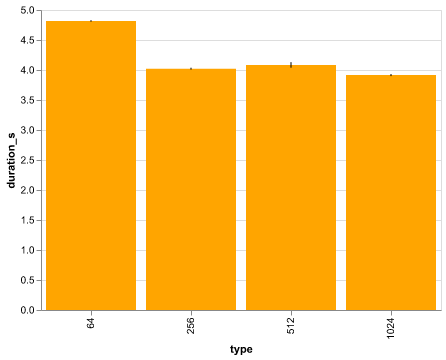

In [40]:
df_bs = df[df.type.str.contains('req')]
df_bs['type'] = df_bs['type'].str.extract('size=(\d+)').astype(int)
base = alt.Chart(df_bs, width=400).mark_bar(color='orange').encode(
    x=alt.X('type:O'), 
    y=alt.Y('mean(duration_s):Q', scale=alt.Scale(zero=True)))
error = base.mark_errorbar(extent='stdev').encode(y='duration_s:Q')
base + error

In [41]:
tm = df.groupby('type').mean().reset_index()
tm = {row.type: row.duration_s for _, row in tm.iterrows()}

sst2_lora_multi = tm['CoLA and SST-2 LoRA (Shuffled, req_size=256)'] - tm['CoLA LoRA']
sst2_standalone = tm['Standalone SST-2']
overhead_s = sst2_lora_multi - sst2_standalone
overhead_fraction = overhead_s / sst2_standalone
sst2_standalone, overhead_s, overhead_fraction * 100

(2.350065435682024, 0.1147209235600064, 4.881605499921438)

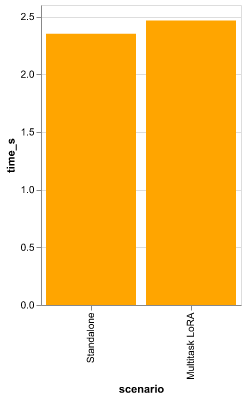

In [42]:
import altair as alt
import pandas as pd
df = pd.DataFrame(data={
    'scenario': ['Standalone', 'Multitask LoRA'],
    'time_s': [sst2_standalone, sst2_lora_multi]
})
alt.Chart(df).mark_bar(color='orange').encode(
    x=alt.X('scenario:O', sort=None), 
    y=alt.Y('time_s:Q', scale=alt.Scale(zero=False))).properties(width=200)

In [43]:
sst2_cola_lora_predictor.delete_model()
sst2_cola_lora_predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: lora-2024-03-31-20-47-23-961
INFO:sagemaker:Deleting endpoint configuration with name: lora-2024-03-31-20-47-23-961
INFO:sagemaker:Deleting endpoint with name: lora-2024-03-31-20-47-23-961


g4dn.xl,roberta-base
```
2024-03-30T12:33:35,918 [INFO ] W-9000-model_1.0 org.pytorch.serve.wlm.WorkerThread - Backend response time: 2020
2024-03-30T12:33:35,918 [INFO ] W-9000-model_1.0 TS_METRICS - WorkerThreadTime.Milliseconds:0.0|#Level:Host|#hostname:container-0.local,timestamp:1711802015
2024-03-30T12:33:35,993 [INFO ] epollEventLoopGroup-3-1 TS_METRICS - ts_inference_requests_total.Count:1.0|#model_name:model,model_version:default|#hostname:container-0.local,timestamp:1711802015
2024-03-30T12:33:35,993 [INFO ] W-9000-model_1.0 org.pytorch.serve.wlm.WorkerThread - Flushing req.cmd PREDICT to backend at: 1711802015993
2024-03-30T12:33:35,994 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Backend received inference at: 1711802015
2024-03-30T12:33:35,995 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Running inference for task: sst2
2024-03-30T12:33:35,995 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Removing adapter cola.
2024-03-30T12:33:35,996 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Installing adapter sst2.
2024-03-30T12:33:35,998 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Changing adapter (remove and install) from cola to sst2 took  2.95 ms.
2024-03-30T12:33:36,984 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Running inference for task: cola
2024-03-30T12:33:36,984 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Removing adapter sst2.
2024-03-30T12:33:36,986 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Installing adapter cola.
2024-03-30T12:33:36,988 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Changing adapter (remove and install) from sst2 to cola took  3.10 ms.
2024-03-30T12:33:37,611 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Inference call returns 891 predictions.
2024-03-30T12:33:37,612 [INFO ] W-9000-model_1.0-stdout org.pytorch.serve.wlm.WorkerLifeCycle - result=[METRICS]PredictionTime.Milliseconds:1618.36|#ModelName:model,Level:Model|#hostname:container-0.local,1711802017,3f4375be-834f-4767-86aa-7d0cdd8cadb3, pattern=[METRICS]
2024-03-30T12:33:37,612 [INFO ] W-9000-model_1.0-stdout MODEL_METRICS - PredictionTime.ms:1618.36|#ModelName:model,Level:Model|#hostname:container-0.local,requestID:3f4375be-834f-4767-86aa-7d0cdd8cadb3,timestamp:1711802017
2024-03-30T12:33:37,613 [INFO ] W-9000-model_1.0 ACCESS_LOG - /169.254.178.2:39592 "POST /invocations HTTP/1.1" 200 1620
2024-03-30T12:33:37,613 [INFO ] W-9000-model_1.0 TS_METRICS - Requests2XX.Count:1.0|#Level:Host|#hostname:container-0.local,timestamp:1711802017
2024-03-30T12:33:37,613 [INFO ] W-9000-model_1.0 TS_METRICS - ts_inference_latency_microseconds.Microseconds:1619743.598|#model_name:model,model_version:default|#hostname:container-0.local,timestamp:1711802017
2024-03-30T12:33:37,613 [INFO ] W-9000-model_1.0 TS_METRICS - ts_queue_latency_microseconds.Microseconds:61.408|#model_name:model,model_version:default|#hostname:container-0.local,timestamp:1711802017
2024-03-30T12:33:37,613 [INFO ] W-9000-model_1.0 TS_METRICS - QueueTime.Milliseconds:0.0|#Level:Host|#hostname:container-0.local,timestamp:1711802017
2024-03-30T12:33:37,613 [INFO ] W-9000-model_1.0 org.pytorch.serve.wlm.WorkerThread - Backend response time: 1619
2024-03-30T12:33:37,613 [INFO ] W-9000-model_1.0 TS_METRICS - WorkerThreadTime.Milliseconds:1.0|#Level:Host|#hostname:container-0.local,timestamp:1711802017
2024-03-30T12:33:37,689 [INFO ] epollEventLoopGroup-3-1 TS_METRICS - ts_inference_requests_total.Count:1.0|#model_name:model,model_version:default|#hostname:container-0.local,timestamp:1711802017
2024-03-30T12:33:37,690 [INFO ] W-9000-model_1.0 org.pytorch.serve.wlm.WorkerThread - Flushing req.cmd PREDICT to backend at: 1711802017690
2024-03-30T12:33:37,690 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Backend received inference at: 1711802017
2024-03-30T12:33:37,692 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Running inference for task: sst2
2024-03-30T12:33:37,692 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Removing adapter cola.
2024-03-30T12:33:37,693 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Installing adapter sst2.
2024-03-30T12:33:37,695 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Changing adapter (remove and install) from cola to sst2 took  3.08 ms.
2024-03-30T12:33:38,863 [INFO ] pool-2-thread-2 ACCESS_LOG - /169.254.178.2:57236 "GET /ping HTTP/1.1" 200 0
2024-03-30T12:33:38,864 [INFO ] pool-2-thread-2 TS_METRICS - Requests2XX.Count:1.0|#Level:Host|#hostname:container-0.local,timestamp:1711802018
2024-03-30T12:33:38,874 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Running inference for task: cola
2024-03-30T12:33:38,875 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Removing adapter sst2.
2024-03-30T12:33:38,876 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Installing adapter cola.
2024-03-30T12:33:38,878 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Changing adapter (remove and install) from sst2 to cola took  3.47 ms.
2024-03-30T12:33:39,716 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Inference call returns 1024 predictions.
2024-03-30T12:33:39,717 [INFO ] W-9000-model_1.0-stdout org.pytorch.serve.wlm.WorkerLifeCycle - result=[METRICS]PredictionTime.Milliseconds:2026.38|#ModelName:model,Level:Model|#hostname:container-0.local,1711802019,5c86f56c-fe59-4cc4-ba9d-bd8ed4049bb2, pattern=[METRICS]
2024-03-30T12:33:39,717 [INFO ] W-9000-model_1.0-stdout MODEL_METRICS - PredictionTime.ms:2026.38|#ModelName:model,Level:Model|#hostname:container-0.local,requestID:5c86f56c-fe59-4cc4-ba9d-bd8ed4049bb2,timestamp:1711802019
2024-03-30T12:33:39,717 [INFO ] W-9000-model_1.0 ACCESS_LOG - /169.254.178.2:39592 "POST /invocations HTTP/1.1" 200 2028
2024-03-30T12:33:39,717 [INFO ] W-9000-model_1.0 TS_METRICS - Requests2XX.Count:1.0|#Level:Host|#hostname:container-0.local,timestamp:1711802019
2024-03-30T12:33:39,717 [INFO ] W-9000-model_1.0 TS_METRICS - ts_inference_latency_microseconds.Microseconds:2027617.502|#model_name:model,model_version:default|#hostname:container-0.local,timestamp:1711802019
2024-03-30T12:33:39,717 [INFO ] W-9000-model_1.0 TS_METRICS - ts_queue_latency_microseconds.Microseconds:87.709|#model_name:model,model_version:default|#hostname:container-0.local,timestamp:1711802019
2024-03-30T12:33:39,717 [INFO ] W-9000-model_1.0 TS_METRICS - QueueTime.Milliseconds:0.0|#Level:Host|#hostname:container-0.local,timestamp:1711802019
2024-03-30T12:33:39,717 [INFO ] W-9000-model_1.0 org.pytorch.serve.wlm.WorkerThread - Backend response time: 2027
2024-03-30T12:33:39,717 [INFO ] W-9000-model_1.0 TS_METRICS - WorkerThreadTime.Milliseconds:0.0|#Level:Host|#hostname:container-0.local,timestamp:1711802019
2024-03-30T12:33:39,854 [INFO ] epollEventLoopGroup-3-1 TS_METRICS - ts_inference_requests_total.Count:1.0|#model_name:model,model_version:default|#hostname:container-0.local,timestamp:1711802019
2024-03-30T12:33:39,854 [INFO ] W-9000-model_1.0 org.pytorch.serve.wlm.WorkerThread - Flushing req.cmd PREDICT to backend at: 1711802019854
2024-03-30T12:33:39,854 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Backend received inference at: 1711802019
2024-03-30T12:33:39,856 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Running inference for task: sst2
2024-03-30T12:33:39,856 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Removing adapter cola.
2024-03-30T12:33:39,857 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Installing adapter sst2.
2024-03-30T12:33:39,859 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Changing adapter (remove and install) from cola to sst2 took  2.99 ms.
2024-03-30T12:33:40,846 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Running inference for task: cola
2024-03-30T12:33:40,846 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Removing adapter sst2.
2024-03-30T12:33:40,847 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Installing adapter cola.
2024-03-30T12:33:40,849 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Changing adapter (remove and install) from sst2 to cola took  2.95 ms.
2024-03-30T12:33:41,466 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Inference call returns 891 predictions.
2024-03-30T12:33:41,468 [INFO ] W-9000-model_1.0-stdout org.pytorch.serve.wlm.WorkerLifeCycle - result=[METRICS]PredictionTime.Milliseconds:1613.48|#ModelName:model,Level:Model|#hostname:container-0.local,1711802021,62e3a39c-2596-4cab-b7d5-226df9568251, pattern=[METRICS]
2024-03-30T12:33:41,468 [INFO ] W-9000-model_1.0-stdout MODEL_METRICS - PredictionTime.ms:1613.48|#ModelName:model,Level:Model|#hostname:container-0.local,requestID:62e3a39c-2596-4cab-b7d5-226df9568251,timestamp:1711802021
2024-03-30T12:33:41,468 [INFO ] W-9000-model_1.0 ACCESS_LOG - /169.254.178.2:39592 "POST /invocations HTTP/1.1" 200 1615
2024-03-30T12:33:41,468 [INFO ] W-9000-model_1.0 TS_METRICS - Requests2XX.Count:1.0|#Level:Host|#hostname:container-0.local,timestamp:1711802021
2024-03-30T12:33:41,468 [INFO ] W-9000-model_1.0 TS_METRICS - ts_inference_latency_microseconds.Microseconds:1614578.676|#model_name:model,model_version:default|#hostname:container-0.local,timestamp:1711802021
2024-03-30T12:33:41,468 [INFO ] W-9000-model_1.0 TS_METRICS - ts_queue_latency_microseconds.Microseconds:71.509|#model_name:model,model_version:default|#hostname:container-0.local,timestamp:1711802021
2024-03-30T12:33:41,468 [INFO ] W-9000-model_1.0 TS_METRICS - QueueTime.Milliseconds:0.0|#Level:Host|#hostname:container-0.local,timestamp:1711802021
2024-03-30T12:33:41,468 [INFO ] W-9000-model_1.0 org.pytorch.serve.wlm.WorkerThread - Backend response time: 1614
2024-03-30T12:33:41,468 [INFO ] W-9000-model_1.0 TS_METRICS - WorkerThreadTime.Milliseconds:0.0|#Level:Host|#hostname:container-0.local,timestamp:1711802021
2024-03-30T12:33:41,582 [INFO ] epollEventLoopGroup-3-1 TS_METRICS - ts_inference_requests_total.Count:1.0|#model_name:model,model_version:default|#hostname:container-0.local,timestamp:1711802021
2024-03-30T12:33:41,582 [INFO ] W-9000-model_1.0 org.pytorch.serve.wlm.WorkerThread - Flushing req.cmd PREDICT to backend at: 1711802021582
2024-03-30T12:33:41,583 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Backend received inference at: 1711802021
2024-03-30T12:33:41,584 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Running inference for task: sst2
2024-03-30T12:33:41,584 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Removing adapter cola.
2024-03-30T12:33:41,585 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Installing adapter sst2.
2024-03-30T12:33:41,587 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Changing adapter (remove and install) from cola to sst2 took  3.02 ms.
2024-03-30T12:33:42,766 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Running inference for task: cola
2024-03-30T12:33:42,766 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Removing adapter sst2.
2024-03-30T12:33:42,767 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Installing adapter cola.
2024-03-30T12:33:42,769 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Changing adapter (remove and install) from sst2 to cola took  2.99 ms.
2024-03-30T12:33:43,605 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Inference call returns 1024 predictions.
2024-03-30T12:33:43,606 [INFO ] W-9000-model_1.0-stdout org.pytorch.serve.wlm.WorkerLifeCycle - result=[METRICS]PredictionTime.Milliseconds:2023.38|#ModelName:model,Level:Model|#hostname:container-0.local,1711802023,025adc14-11d9-4953-9228-070763ef21f6, pattern=[METRICS]
2024-03-30T12:33:43,607 [INFO ] W-9000-model_1.0-stdout MODEL_METRICS - PredictionTime.ms:2023.38|#ModelName:model,Level:Model|#hostname:container-0.local,requestID:025adc14-11d9-4953-9228-070763ef21f6,timestamp:1711802023
2024-03-30T12:33:43,607 [INFO ] W-9000-model_1.0 ACCESS_LOG - /169.254.178.2:39592 "POST /invocations HTTP/1.1" 200 2025
2024-03-30T12:33:43,607 [INFO ] W-9000-model_1.0 TS_METRICS - Requests2XX.Count:1.0|#Level:Host|#hostname:container-0.local,timestamp:1711802023
2024-03-30T12:33:43,607 [INFO ] W-9000-model_1.0 TS_METRICS - ts_inference_latency_microseconds.Microseconds:2024551.595|#model_name:model,model_version:default|#hostname:container-0.local,timestamp:1711802023
2024-03-30T12:33:43,607 [INFO ] W-9000-model_1.0 TS_METRICS - ts_queue_latency_microseconds.Microseconds:77.242|#model_name:model,model_version:default|#hostname:container-0.local,timestamp:1711802023
2024-03-30T12:33:43,607 [INFO ] W-9000-model_1.0 TS_METRICS - QueueTime.Milliseconds:0.0|#Level:Host|#hostname:container-0.local,timestamp:1711802023
2024-03-30T12:33:43,607 [INFO ] W-9000-model_1.0 org.pytorch.serve.wlm.WorkerThread - Backend response time: 2024
2024-03-30T12:33:43,607 [INFO ] W-9000-model_1.0 TS_METRICS - WorkerThreadTime.Milliseconds:1.0|#Level:Host|#hostname:container-0.local,timestamp:1711802023
2024-03-30T12:33:43,694 [INFO ] epollEventLoopGroup-3-1 TS_METRICS - ts_inference_requests_total.Count:1.0|#model_name:model,model_version:default|#hostname:container-0.local,timestamp:1711802023
2024-03-30T12:33:43,694 [INFO ] W-9000-model_1.0 org.pytorch.serve.wlm.WorkerThread - Flushing req.cmd PREDICT to backend at: 1711802023694
2024-03-30T12:33:43,695 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Backend received inference at: 1711802023
2024-03-30T12:33:43,696 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Running inference for task: sst2
2024-03-30T12:33:43,696 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Removing adapter cola.
2024-03-30T12:33:43,697 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Installing adapter sst2.
2024-03-30T12:33:43,699 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Changing adapter (remove and install) from cola to sst2 took  3.19 ms.
2024-03-30T12:33:43,864 [INFO ] pool-2-thread-2 ACCESS_LOG - /169.254.178.2:57236 "GET /ping HTTP/1.1" 200 1
2024-03-30T12:33:43,864 [INFO ] pool-2-thread-2 TS_METRICS - Requests2XX.Count:1.0|#Level:Host|#hostname:container-0.local,timestamp:1711802023
2024-03-30T12:33:44,688 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Running inference for task: cola
2024-03-30T12:33:44,688 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Removing adapter sst2.
2024-03-30T12:33:44,689 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Installing adapter cola.
2024-03-30T12:33:44,691 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Changing adapter (remove and install) from sst2 to cola took  3.11 ms.
2024-03-30T12:33:45,310 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Inference call returns 891 predictions.
2024-03-30T12:33:45,311 [INFO ] W-9000-model_1.0-stdout org.pytorch.serve.wlm.WorkerLifeCycle - result=[METRICS]PredictionTime.Milliseconds:1616.61|#ModelName:model,Level:Model|#hostname:container-0.local,1711802025,c60b8632-6396-41bf-9dc0-2cdfb17ea11f, pattern=[METRICS]
2024-03-30T12:33:45,312 [INFO ] W-9000-model_1.0-stdout MODEL_METRICS - PredictionTime.ms:1616.61|#ModelName:model,Level:Model|#hostname:container-0.local,requestID:c60b8632-6396-41bf-9dc0-2cdfb17ea11f,timestamp:1711802025
2024-03-30T12:33:45,312 [INFO ] W-9000-model_1.0 ACCESS_LOG - /169.254.178.2:39592 "POST /invocations HTTP/1.1" 200 1618
2024-03-30T12:33:45,312 [INFO ] W-9000-model_1.0 TS_METRICS - Requests2XX.Count:1.0|#Level:Host|#hostname:container-0.local,timestamp:1711802025
2024-03-30T12:33:45,312 [INFO ] W-9000-model_1.0 TS_METRICS - ts_inference_latency_microseconds.Microseconds:1617942.474|#model_name:model,model_version:default|#hostname:container-0.local,timestamp:1711802025
2024-03-30T12:33:45,312 [INFO ] W-9000-model_1.0 TS_METRICS - ts_queue_latency_microseconds.Microseconds:73.046|#model_name:model,model_version:default|#hostname:container-0.local,timestamp:1711802025
2024-03-30T12:33:45,312 [INFO ] W-9000-model_1.0 TS_METRICS - QueueTime.Milliseconds:0.0|#Level:Host|#hostname:container-0.local,timestamp:1711802025
2024-03-30T12:33:45,312 [INFO ] W-9000-model_1.0 org.pytorch.serve.wlm.WorkerThread - Backend response time: 1618
2024-03-30T12:33:45,312 [INFO ] W-9000-model_1.0 TS_METRICS - WorkerThreadTime.Milliseconds:0.0|#Level:Host|#hostname:container-0.local,timestamp:1711802025
2024-03-30T12:33:48,864 [INFO ] pool-2-thread-2 ACCESS_LOG - /169.254.178.2:39592 "GET /ping HTTP/1.1" 200 0
2024-03-30T12:33:48,864 [INFO ] pool-2-thread-2 TS_METRICS - Requests2XX.Count:1.0|#Level:Host|#hostname:container-0.local,timestamp:1711802028
```